### IT Security and Privacy
### HU WS 2019/2020
# Extremism Detection: Data Scraping and Preparation

---




*Amanda Maiwald, 599665, maiwald@posteo.de* \\
*Lukas Baumann, 597742, lukasb94@gmx.de* \\
Simon Rähles, 600785, s.raehles@me.com \\

## Google drive connection and import of packages

READ ME:
As we have different file structures in our respective google drive, we need to define separate paths to save files externally. Please define your own path where you want to save and load files from. When using this code, only change the variable *output_dir* and *input_dir*.

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Individual paths to directories.

In [0]:
# Amanda's directory structure
#input_dir_am = "/content/drive/My Drive/ISP_Extremism_Detection/ISP_Colab/Input/"
#output_dir_am = "/content/drive/My Drive/ISP_Extremism_Detection/ISP_Colab/Output/"

In [0]:
# Lukas's directory structure
#input_dir_lb = "/content/drive/My Drive/ISP_Extremism_Detection/ISP_Colab/Input/"
#output_dir_lb = "/content/drive/My Drive/ISP_Extremism_Detection/ISP_Colab/Outp"

In [0]:
# Simon's directory structure
#input_dir_sr = "/content/drive/shared with me/ISP_Extremism_Detection/ISP_Colab/Input/"
#output_dir_sr = "/content/drive/shared with me/ISP_Extremism_Detection/ISP_Colab/Output/"

In [0]:
# set directory to individual directory (right now it is Amanda's)
#input_dir = input_dir_sr
#output_dir = output_dir_sr

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import numpy as np
import torch 
import sklearn
import time
import GetOldTweets3 as got #  https://pypi.org/project/GetOldTweets3/
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

os.getcwd()

'/Users/sraehles/Downloads'

### Import account data

In [0]:
# afd accounts
#google_sheet_all= 'https://docs.google.com/spreadsheets/d/1Wz7K_eSx72JIanjSwsD_btxSLTaw839a6iLvt3O9KAc/edit#gid=423768268'

# replace “edit#gid” text in the google_sheet_url variable above with “export?format=csv&gid”
#new_google_sheet_all = 'https://docs.google.com/spreadsheets/d/1Wz7K_eSx72JIanjSwsD_btxSLTaw839a6iLvt3O9KAc/export?format=csv&gid=423768268'

# import data

accounts_all = pd.read_csv("final_df_all_accounts.csv")

/Users/sraehles/opt/anaconda3/envs/ITSec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
print(accounts_all.head(3))

   Unnamed: 0  Unnamed: 0.1          user        id  \
0           0             0  Alice_Weidel  1,22E+34   
1           1             1  Alice_Weidel  1,22E+34   
2           2             2  Alice_Weidel  1,21E+34   

                                           permalink   to  \
0  https://twitter.com/Alice_Weidel/status/121664...  NaN   
1  https://twitter.com/Alice_Weidel/status/121563...  NaN   
2  https://twitter.com/Alice_Weidel/status/121485...  NaN   

                                                text  \
0  Vor 75 Jahren flohen 2,5 Millionen Deutsche vo...   
1  Islamisierung und Indoktrination aus Ankara ve...   
2  Mein herzliches Beileid den Angehörigen der Op...   

                        date  retweets  favorites mentions  \
0  2020-01-13 09:09:20+00:00     904.0     3715.0      NaN   
1  2020-01-10 14:14:47+00:00     567.0     2142.0      NaN   
2  2020-01-08 10:20:19+00:00     265.0     1516.0      NaN   

                             hashtags  geo          name par

In [0]:
print("Shape of accounts_all: ", accounts_all.shape)

Shape of accounts_all:  (469337, 17)


In [0]:
#Count unique user
print(accounts_all['user'].nunique())

129


In [0]:
df = accounts_all.copy()

In [0]:
df.shape

(469337, 17)

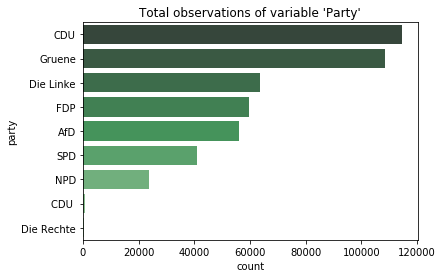

In [0]:
plt.title("Total observations of variable 'Party'") 
sns.countplot(y = "party", data = df, order = accounts_all['party'].value_counts().index,
 palette = "Greens_d")

In [0]:
# "CDU " to "CDU"
df['party'] = df['party'].replace('CDU ', 'CDU')

In [0]:
# Separate AfD
df_afd = df[df.party == 'AfD']
df = df[df.party != 'AfD']

In [0]:
# Label Data as extremist and non extremist
extremist_parties = ['NPD', 'Die Rechte']
df['label'] = ['extremist' if x in extremist_parties else 'non_extremist' for x in df['party']]

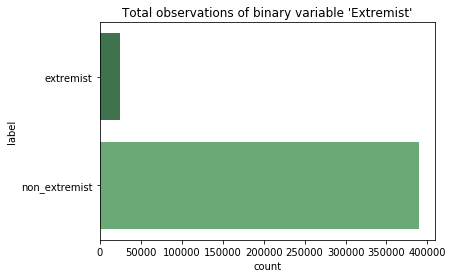

In [0]:
# Plot distribution between extremist and non extremist tweets
plt.title("Total observations of binary variable 'Extremist'") 
sns.countplot(y = "label", data = df,
 palette = "Greens_d")

In [0]:
# set percentage of right and not right data in data set for machine learning
right_percent = 0.5
not_right_percent = 1 - right_percent

In [0]:
# Separate majority and minority classes
df_majority = df[df.label == 'non_extremist']
df_minority = df[df.label == 'extremist']

print('Number of extremist tweets: \t', len(df_minority))
print('Number of non extremist tweets:\t', len(df_majority))

Number of extremist tweets: 	 24272
Number of non extremist tweets:	 389122


In [0]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace = False,    # sample without replacement
                                 n_samples = len(df_minority)*1,     # to match minority class
                                 random_state = 123)

In [0]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

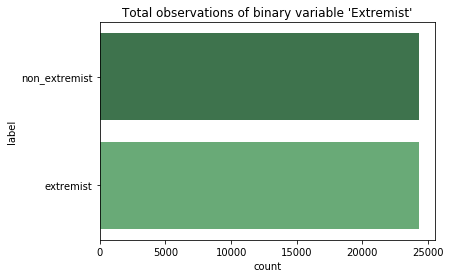

In [0]:
# Plot distribution between extremist and non extremist tweets
plt.title("Total observations of binary variable 'Extremist'") 
sns.countplot(y = "label", data = df_downsampled,
 palette = "Greens_d")

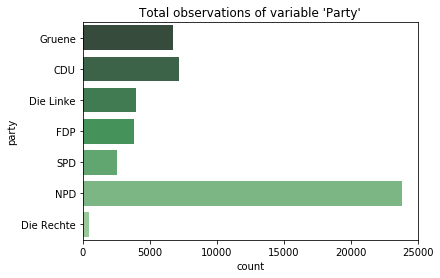

In [0]:
plt.title("Total observations of variable 'Party'") 
sns.countplot(y="party", data=df_downsampled,
 palette="Greens_d")

### Text Cleaning

In [0]:
from nltk.stem.snowball import SnowballStemmer
germanStemmer = SnowballStemmer("german")

In [0]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/sraehles/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sraehles/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sraehles/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
## currently not used as tweets are in german

# Lemmatize with POS Tag
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [0]:
def clean_sentences(df):
    tweets = []

    for sent in df:

        #remove links
        tweet = re.sub(r'http\S+', '', sent, flags=re.MULTILINE)

        #remove non-alphabetic characters
        tweet = re.sub("[^a-zöüäA-ZÜÖÄ]"," ", tweet)
    
        # Tokenize the sentences
        words = word_tokenize(tweet.lower(), language = 'german')
  
        # Lemmatize each word to its lemma
        #lemma_words = [germanStemmer.stem(i) for i in words]

        tweets.append(words)

    return(tweets)

In [0]:
start = time.time()
X_text_clean = clean_sentences(df_downsampled['text'].astype(str))
end = time.time()
print('Time for tokenization with 100% of data:', (end-start)/60)

Time for tokenization with 100% of data: 0.10825800100962321


In [0]:
print('Before preprocessing: \t', df_downsampled.text.iloc[0])
print('After preprocessing: \t', X_text_clean[0])

Before preprocessing: 	 Wer Rettungsschirm gesagt hat, muss Hebel sagen - das ist seit Wochen klar, alles andere war Augenwischerei, nicht zuletzt von Schäuble
After preprocessing: 	 ['wer', 'rettungsschirm', 'gesagt', 'hat', 'muss', 'hebel', 'sagen', 'das', 'ist', 'seit', 'wochen', 'klar', 'alles', 'andere', 'war', 'augenwischerei', 'nicht', 'zuletzt', 'von', 'schäuble']


In [0]:
full_text = []

for tweet in X_text_clean:
  for token in tweet:
    full_text.append(token)

print('Total number of tweets: \t', len(X_text_clean))
print('Total number of tokens: \t', len(full_text))
print('Average tweet length: \t \t', len(full_text)/len(X_text_clean))

Total number of tweets: 	 48544
Total number of tokens: 	 705726
Average tweet length: 	 	 14.537862557679631


In [0]:
import collections
# Create a Wordcloud
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words("german")
stop_words.append('amp')
stop_words.append('gt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sraehles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
wordcount = collections.defaultdict(int)

for word in full_text:
  if word not in stop_words:
    wordcount[word] += 1

# the x most used words
to_print = 50

mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]

In [0]:
# Show most occuring words
for word, count in mc[0:50]:
    print(word, ":", count)

heute : 3238
npd : 3047
mehr : 1822
mal : 1605
deutschland : 1490
geht : 1443
schon : 1417
ja : 1361
cdu : 1318
rt : 1311
spd : 1277
immer : 1105
wer : 1103
afd : 1031
gibt : 996
berlin : 975
beim : 959
youtube : 928
gut : 889
fdp : 858
nrw : 849
gro : 843
e : 842
morgen : 835
linke : 818
danke : 807
europa : 805
gute : 765
s : 756
gerade : 756
eu : 743
merkel : 720
statt : 713
müssen : 708
a : 697
jn : 697
ab : 686
en : 684
tag : 672
land : 670
menschen : 663
video : 653
wurde : 639
beitrag : 629
zeit : 626
politik : 618
macht : 614
sachsen : 612
neue : 601
neuer : 583


In [0]:
# remove parties and single characters from the tweets
remove = ['spd', 'ddw', 'afd', 'linke', 'cdu', 'npd', 'gruene', 'grüne','fdp', 'csu',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h','i', 'j','k','l','m','n','o','p','q',
          'r','s','t','u','v','w','x','y','z']

X_text = []

for tweet in X_text_clean:
  X_text.append([word for word in tweet if word not in remove])

In [0]:
full_text = []

for tweet in X_text:
  for token in tweet:
    full_text.append(token)

In [0]:
wordcount = collections.defaultdict(int)

for word in full_text:
  if word not in stop_words:
    wordcount[word] += 1

# the x most used words
to_print = 50

mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]

In [0]:
# Show most occuring words
for word, count in mc[0:50]:
    print(word, ":", count)

heute : 3238
mehr : 1822
mal : 1605
deutschland : 1490
geht : 1443
schon : 1417
ja : 1361
rt : 1311
immer : 1105
wer : 1103
gibt : 996
berlin : 975
beim : 959
youtube : 928
gut : 889
nrw : 849
gro : 843
morgen : 835
danke : 807
europa : 805
gute : 765
gerade : 756
eu : 743
merkel : 720
statt : 713
müssen : 708
jn : 697
ab : 686
en : 684
tag : 672
land : 670
menschen : 663
video : 653
wurde : 639
beitrag : 629
zeit : 626
politik : 618
macht : 614
sachsen : 612
neue : 601
neuer : 583
de : 565
recht : 552
deutschen : 551
viele : 548
ganz : 545
deutsche : 532
endlich : 523
facebook : 499
kommt : 498


In [0]:
print(df.shape)
print(df_afd.shape)
print(df_downsampled.shape)

(413394, 18)
(55943, 17)
(48544, 18)


### Export the final data for our model 

In [0]:
df.to_csv('df_all_accounts.csv', index=False)
df_afd.to_csv('df_afd.csv', index=False)
df_downsampled.to_csv('df_downsampled.csv', index=False)